# Introduction

In this project I'm building three models to predict insurance costs in the US based on user profile like their age, sex, bmi, region, etc. One of the purpose is to make sure that you're actually being charged _fairly_ or at least within reasonable range.

After building the models, I'm going to chose which model is the most appropriate to use based on the loss of the model on the test set.

* The first model is a naive model, as it always predicts the mean of the dataset. This serves as the "baseline" error. If our model can't beat this naive classifier, then something's probably wrong with the model.
* The second model uses RandomForestRegrssor + GridSearchCV. I'm picking RandomForestRegressor to minimize the chance of overfitting and improve accuracy. I'm using GridSearchCV to help me search for the best parameter.
* The third model uses Keras (TensorFlow) that consists of Dense and Dropout layers. I'm using adam optimizer because based on experience, it performs best for most situations.

# Grabbing the data

The dataset is a .csv file obtained from Kaggle, https://www.kaggle.com/mirichoi0218/insurance.

To make this notebook portable, I already downloaded this .csv file and store it somewhere else so we can just wget it.

In [1]:
!wget https://lambda.sx/kbmD.zip -O insurance.zip
!unzip insurance.zip

--2021-03-18 09:04:46--  https://lambda.sx/kbmD.zip
Resolving lambda.sx (lambda.sx)... 104.21.5.169, 172.67.133.166, 2606:4700:3030::6815:5a9, ...
Connecting to lambda.sx (lambda.sx)|104.21.5.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16025 (16K) [application/zip]
Saving to: ‘insurance.zip’

insurance.zip       100%[===================>]  15.65K  --.-KB/s    in 0s      

2021-03-18 09:04:46 (75.1 MB/s) - ‘insurance.zip’ saved [16025/16025]

Archive:  insurance.zip
  inflating: insurance.csv           


Let's see what it looks like.

In [2]:
import numpy as np 
import pandas as pd 

insurance_dataset = pd.read_csv('insurance.csv')
insurance_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Inspecting the data

Let's see the correlation for the numerical columns.

In [3]:
insurance_dataset.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


It seems like the amount of children doesn't really correlate much with insurance charges. The main factors are age and BMI.

Now we'll see the statistics for the numerical columns

In [5]:
insurance_dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Couple things to note:

* Max charge is super high (about 64000) compared to the top 75% (about 17000). Sign of outliers. I will investigate if these outliers are just for this one value or if there are many more.
* Standard deviation for charges is pretty high. With the current range and variation, I expect this will made an impact to the model, so we shouldn't be expecting insanely accurate models (otherwise this could be a sign of overfitting).

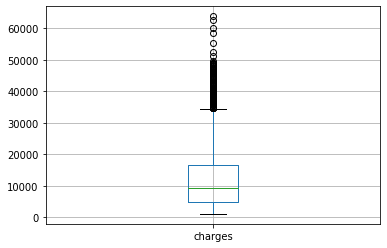

In [6]:
insurance_dataset.boxplot(column=['charges'])

Sure enough, there are many outliers. Because there are many outliers, we shouldn't really remove them. This is because those outliers are actually part of the data and tells something about the distribution.

# Cleaning the data

Let's see if there's an empty entry within the columns. If there is, then we need some kind of imputer or we just drop the column entirely, depending on how much empty entry there are.

In [7]:
insurance_dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Now we check each categorical columns to make sure there are no duplicates like "yes" and "Yes", or "no" and "NO" and "No".

In [8]:
insurance_dataset['sex'].unique()

array(['female', 'male'], dtype=object)

In [9]:
insurance_dataset['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [10]:
insurance_dataset['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

Data looks fine. Now we visualize them.

# Exploring the data (visualizations)

To visualize the plot, I'm going to do a scatterplot for age, bmi, sex, and the charges. Red circle denotes female and blue circle denotes male. The amount of charges determines the size of the circle.

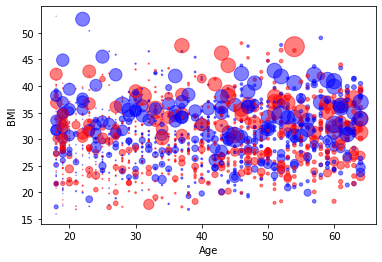

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

sizes = (20*insurance_dataset['charges']/max(insurance_dataset['charges']))**2
colors = ['red' if sex == 'female' else 'blue'
          for sex in insurance_dataset['sex']]

plt.scatter(insurance_dataset['age'], 
            insurance_dataset['bmi'],
            s=sizes,
            c=colors,
            alpha=0.5)

plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

I'm going to conclude that there's no significant correlation between sex and insurance charges. My next assumption is the smoking column.

Now let's do the same thing, but we change the colors. The colors are now determined by the **smoking column**. Red means the person smokes, blue otherwise.  
To make it portable, I've copy pasted the same code from above so we don't have to run both cell everytime we wanted to see the second plot.

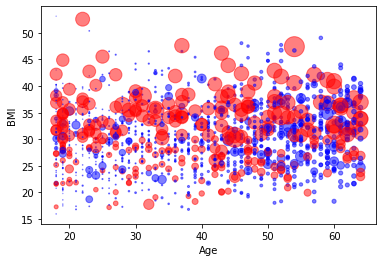

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

sizes = (20*insurance_dataset['charges']/max(insurance_dataset['charges']))**2
colors = ['red' if smoke == 'yes' else 'blue'
          for smoke in insurance_dataset['smoker']]

plt.scatter(insurance_dataset['age'], 
            insurance_dataset['bmi'],
            s=sizes,
            c=colors,
            alpha=0.5)
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

There seems to be a strong correlation between smoking and the insurance charges

I also noticed that there seems to be a bunch of tightly packed circles on the left. Let's see the histogram for age-frequency

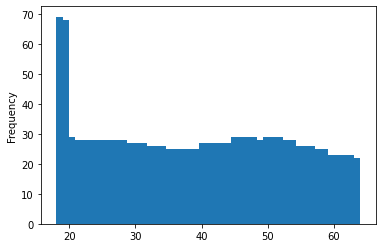

In [13]:
insurance_dataset['age'].plot(kind="hist", bins=len(set(insurance_dataset['age'])))

So many insurances for age 18-19. There are two ways of interpreting this. Either:

* Most people buy insurance as soon as possible to qualify for lower premiums, or
* Since this is a "medical cost" dataset, this could just mean that people between 18-19 just go to the hospital more often. But this doesn't explain why suddenly people at the age of 20 go to the hospital less often.

# Preprocessing

There are 1338 entires. First we drop the 'sex' column, then we shuffle those entries. After shuffling, we split the data:

* 70% for train set
* 15% for validation set
* 15% for test set

In [14]:
# Drop the 'sex' column since it has no significant correlation with charge.
insurance_dropped = insurance_dataset.drop(['sex'], axis=1)

# Shuffling data
shuffled_dataset = insurance_dropped.sample(frac=1, random_state=1)

# Splitting data, 70% train, 15% validation, 15% test
train, validation, test = np.split(shuffled_dataset, [int(.7*len(shuffled_dataset)), 
                                                      int(.85*len(shuffled_dataset))])

print(len(train), len(validation), len(test))
print(train.head())

936 201 201
      age    bmi  children smoker     region     charges
559    19  35.53         0     no  northwest   1646.4297
1087   57  31.54         0     no  northwest  11353.2276
1020   51  37.00         0     no  southwest   8798.5930
460    49  36.63         3     no  southeast  10381.4787
802    21  22.30         1     no  southwest   2103.0800


The Pipeline for the data:
* StandardScaler for age, bmi, and children
* OneHotEncoder for sex, smoker and region

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline to transform numerical columns
num_columns = ['age', 'bmi', 'children']
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

cat_columns = ['smoker', 'region']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('cat', OneHotEncoder(), cat_columns),
])

Now we transform `train`, `validation`, and `test` to `X` and `y` that will be used later

In [22]:
y_train = train['charges']
X_train = full_pipeline.fit_transform(train.drop(['charges'], axis=1))

# only call transform because we don't want to bias the model with 
# validation or test data
y_valid = validation['charges']
X_valid = full_pipeline.transform(validation.drop(['charges'], axis=1))

y_test = test['charges']
X_test = full_pipeline.transform(test.drop(['charges'], axis=1))

# Naive model - always predict the mean

We'll build a naive model that always predict the mean. Then, we see the mean absolute error.

$$mae = \dfrac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$$

where $N$ is the amount of data, $y_i$ is the actual value, and $\hat{y}_i$ is predicted value (in this case, this is always set to the mean)

In [17]:
train_mean = train['charges'].mean()
mae = (abs(train['charges']-train_mean)).sum()/len(train)

print('naive mae:', mae)

naive mae: 8861.963885950448


# sklearn model - RandomForestRegressor + GridSearchCV

Now I'm trying RandomForestRegressor. Another purpose of building this model is to see what's the rough error for the model. To get the best parameters, I use GridSearchCV.

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

grid = [
    {'n_estimators': [2, 16, 64, 128], 'max_features': [2, 8, 9]}
]

model = RandomForestRegressor(random_state=1)
grid_search = GridSearchCV(model, grid, cv=5,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [19]:
for mean, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(-mean, params)

3703.7020299997153 {'max_features': 2, 'n_estimators': 2}
2957.477995640401 {'max_features': 2, 'n_estimators': 16}
2830.4554167118663 {'max_features': 2, 'n_estimators': 64}
2825.9176300751083 {'max_features': 2, 'n_estimators': 128}
3171.602291663844 {'max_features': 8, 'n_estimators': 2}
2847.9664693817517 {'max_features': 8, 'n_estimators': 16}
2776.944395052148 {'max_features': 8, 'n_estimators': 64}
2763.9541795042687 {'max_features': 8, 'n_estimators': 128}
3135.167799924042 {'max_features': 9, 'n_estimators': 2}
2860.737486111946 {'max_features': 9, 'n_estimators': 16}
2768.299766868821 {'max_features': 9, 'n_estimators': 64}
2775.514939091813 {'max_features': 9, 'n_estimators': 128}


In [20]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 128}

We obtained 2764 mae for 9 `max_features` and 64 `n_estimators`. Let's try building a neural network and see if we can do better.

# Keras model

The Keras model consists of:

* A Dense layer with 256 units
* A Dropout layer with 0.3 chance of randomly dropping out certain neurons
* A Dense layer with 128 units
* A Dropout layer with 0.2 chance
* A Dense layer with 64 units
* A Dropout layer with 0.1 chance
* A final dense layer predicting the charges

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout

model = keras.Sequential()
model.add(Dense(256, activation='relu', input_shape=[9]))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=64,
                    epochs=150)

Epoch 1/150
15/15 [==============================] - 1s 15ms/step - loss: 12847.8718 - val_loss: 13718.2324
Epoch 2/150
15/15 [==============================] - 0s 6ms/step - loss: 13713.4258 - val_loss: 13701.0596
Epoch 3/150
15/15 [==============================] - 0s 5ms/step - loss: 13431.4512 - val_loss: 13638.8281
Epoch 4/150
15/15 [==============================] - 0s 5ms/step - loss: 13101.6563 - val_loss: 13455.9053
Epoch 5/150
15/15 [==============================] - 0s 6ms/step - loss: 13093.9057 - val_loss: 13009.1328
Epoch 6/150
15/15 [==============================] - 0s 6ms/step - loss: 12503.5825 - val_loss: 12096.6758
Epoch 7/150
15/15 [==============================] - 0s 6ms/step - loss: 10849.4185 - val_loss: 10658.9678
Epoch 8/150
15/15 [==============================] - 0s 6ms/step - loss: 9967.9183 - val_loss: 8911.2012
Epoch 9/150
15/15 [==============================] - 0s 6ms/step - loss: 8152.4891 - val_loss: 7949.9438
Epoch 10/150
15/15 [====================

To see how far the `loss` and `val_loss` has improved, we plot the `history` of the model.

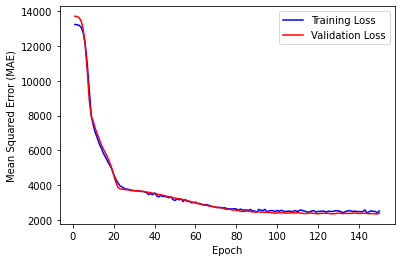

In [27]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, training_loss, 'b-')
plt.plot(epochs, validation_loss, 'r-')

plt.legend(['Training Loss', 'Validation Loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MAE)')

plt.show();

For the Keras model, we obtained around 2441 mae for the validation set. The Keras model performed better than the sklearn model. At least for the validation set. The real evaluation is with the test set.

# Testing all models (test set)

In [28]:
from sklearn.metrics import mean_absolute_error

# MAE for naive model
test_mean = test['charges'].mean()
naive_mae = (abs(test['charges']-test_mean)).sum()/len(test)
print('Naive mae (test):', naive_mae)

# MAE for sklearn model
y_predict = grid_search.predict(X_test)
sklearn_mae = mean_absolute_error(y_test, y_predict)
print('sklearn mae (test):', sklearn_mae)

# MAE for Keras model
keras_mae = model.evaluate(X_test, y_test, batch_size=64)
print('Keras mae (test):')
print(keras_mae)

Naive mae (test): 9871.91931374421
sklearn mae (test): 2505.8761260421734
4/4 [==============================] - 0s 3ms/step - loss: 1955.4220
Keras mae (test):
1955.4219970703125


# Visualizing model performance

We will now plot all of the predictions of each model. Starting with the naive model

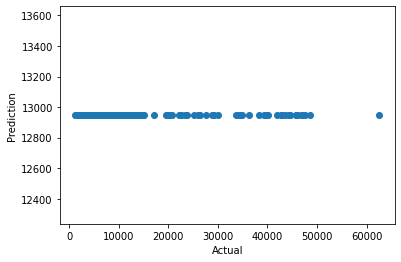

In [29]:
plt.scatter(y_test, [test_mean for x in range(len(y_test))])

plt.xlabel('Actual')
plt.ylabel('Prediction')

plt.show()

Here is the prediction plot for the sklearn model

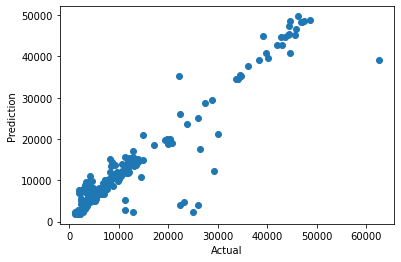

In [30]:
plt.scatter(y_test, y_predict)

plt.xlabel('Actual')
plt.ylabel('Prediction')

plt.show()

And here is the prediction for the Keras model.

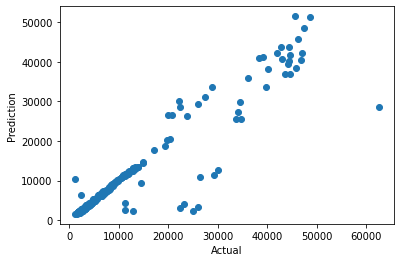

In [31]:
keras_predict = model.predict(X_test)

plt.scatter(y_test, keras_predict)

plt.xlabel('Actual')
plt.ylabel('Prediction')

plt.show()

# Summary

## Model comparison

Here is the mean absolute error for each model on the test set (rounded to whole number. lower is better):

| Model   | Mean Absolute Error (MAE) |
|---------|---------------------------|
| Naive   | 9872                      |
| sklearn | 2875                      |
| Keras   | 2064                      |

Therefore, I'm going to pick the Keras model because it generalises much better and is overall better for predictions.

## What did I learn?

* Building a baseline model is important

This is so you know if your model is performing better than a "naive" model. A binary classifier that accurately classifies 100 objects with the same class out of 105 objects, is not better than a binary classifier that always guess that same class for those 105 objects (you also need a better metric to measure the performance of your model like the F1 score for classifier)

## What could be improved?

* More data

The model could definitely be improved with more data. Not just the amount of data, but the quality of data as well. Since it is insurance, it would also be useful to know the hobbies of the person. This is because certain hobbies pose certain risks. Therefore, might impose higher charges.